In [1]:
import pandas as pd 
import numpy as np
%pylab inline
matplotlib.rcParams['figure.figsize'] = [16, 8]
plt.rcParams.update({'font.size': 15})

AgentType = ["poorHigh","poorLow","richHigh","richLow"]
Beta_r = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.10]
Gamma = [3.0]

Populating the interactive namespace from numpy and matplotlib


In [22]:
import numpy as np
import jax.numpy as jnp
from jax import jit, random, vmap
from functools import partial
from tqdm import tqdm
import pandas as pd
import warnings

beta_r = 0.1
gamma = 3.0
agentType = "poorHigh"

'''
    Input: beta_r, agentType, gamma
'''
# discounting factor
beta = 1/(1+beta_r)
# time line, starts at 20 ends at 80
T_min = 0
T_max = 60
T_R = 45
# relative importance of housing consumption and non durable consumption 
alpha = 0.7
# parameter used to calculate the housing consumption 
kappa = 0.3
# uB associated parameter
B = 2.0
# social welfare after the unemployment
welfare = 20
# tax rate before and after retirement
tau_L = 0.2
tau_R = 0.1
# number of states S
nS = 8
# number of states e
nE = 2
# housing state
nO = 2
# experience state 
nZ = 2

'''
    Economic state calibration 
'''

# probability of survival
Pa = jnp.array(np.load("constant/prob.npy"))
############################################################################################################ skill and finance literacy 
if "rich" in agentType:
    # deterministic income
    detEarning = jnp.array(np.load("constant/highIncomeDetermined.npy"))
else:
    detEarning = jnp.array(np.load("constant/lowIncomeDetermined.npy"))
    
if "High" in agentType:
    # stock transaction fee
    Kc = 0.02
    # stock participation cost
    c_k = 20
else:
    # stock transaction fee
    Kc = 0
    # stock participation cost
    c_k = 5
############################################################################################################ 
# Define transition matrix of economical states S
Ps = np.genfromtxt('constant/Ps.csv',delimiter=',')
Ps = jnp.array(Ps)
# The possible GDP growth, stock return, bond return
gkfe = np.genfromtxt('constant/gkfe.csv',delimiter=',')
gkfe = jnp.array(gkfe)
# GDP growth depending on current S state
gGDP = gkfe[:,0]/100
# risk free interest rate depending on current S state 
r_b = gkfe[:,1]/100
# stock return depending on current S state
r_k = gkfe[:,2]/100
# unemployment rate depending on current S state 
Pe = gkfe[:,7:]/100
Pe = Pe[:,::-1]
# consumption lower boundary 
c_bar = jnp.array(np.load("constant/c_bar.npy"))

'''
    calculate stationary distribution to prepare for simulation
'''
# calculate the stationary distribution of econ state and employment state
S_distribution = jnp.ones(nS)/nS
for _ in range(100):
    S_distribution = jnp.matmul(S_distribution, Ps)

#P(0,1)
P01 = jnp.dot(Pe[:,0],S_distribution)
#P(1,0)
P10 = jnp.dot(Pe[:,1],S_distribution)
jnp.array([[1-P01, P01],[P10, 1-P10]])

E_distribution = jnp.ones(2)/2
for _ in range(100):
    E_distribution = jnp.matmul(E_distribution, jnp.array([[1-P01, P01],[P10, 1-P10]]))


'''
    401k related constants
'''
# 401k amount growth rate
r_bar = 0.02
# income fraction goes into 401k 
yi = 0.04
Pa = Pa[:T_max]
Nt = [np.sum(Pa[t:]) for t in range(T_min,T_max)]
# factor used to calculate the withdraw amount 
Dn = [(r_bar*(1+r_bar)**N)/((1+r_bar)**N - 1) for N in Nt]
Dn[-1] = 1
Dn = jnp.array(Dn)
# cash accumulated before retirement 
nEarning = yi*E_distribution[1]*(1+jnp.dot(S_distribution,gGDP))*detEarning[:45]
n_balance = np.zeros(T_R)
for t in range(T_R):
    nMultiplier = jnp.array([(1+r_bar)**(t-i) for i in range(t)])
    n_balance[t] = (nEarning[:t] * nMultiplier).sum()
# cash payouts after retirement 
n_payout = []
amount = n_balance[-1]
for t in range(45, 60):
    n_payout.append(amount*Dn[t])
    amount = amount - amount*Dn[t]
    n_balance = jnp.append(n_balance,amount)
n_payout = jnp.array(n_payout)


'''
    housing related constants
'''
# variable associated with housing and mortgage 
# age limit of buying a house
ageLimit = 30
mortgageLength = 30
# mortgage rate 
rh = 0.045
# housing unit
H = 1000
# max rent unit
Rl = 500
# housing price constant 
pt = 2*250/1000
# 30k rent 1000 sf
pr = 2*10/1000 * 2 
# constant cost 
c_h = 5
c_s = H*pt*0.4
# Dm is used to update the mortgage payment
Dm = [(1+rh) - rh*(1+rh)**(T_max - t)/((1+rh)**(T_max-t)-1) for t in range(T_min, T_max)]
Dm[-1] = 0
Dm = jnp.array(Dm)
# 30 year mortgage
Ms = []
M = H*pt*0.8
m = M*(1+rh) - Dm[30]*M
for i in range(30, T_max):
    Ms.append(M)
    M = M*(1+rh) - m
Ms.append(0)
Ms = jnp.array(Ms)


'''
    Discretize the state space
    Discretize the action space 
'''
# actions dicretization(hp, cp, kp)
numGrid = 20
As = np.array(np.meshgrid(np.linspace(0.001,0.999,numGrid), np.linspace(0,1,numGrid), [0,1])).T.reshape(-1,3)
As = jnp.array(As)
# wealth discretization
wealthLevel = 300
polynomialDegree = 2
ws = jnp.linspace(0, np.power(wealthLevel,1/polynomialDegree), numGrid)**polynomialDegree
# age of last time bought a house value only count when o = 1. 
aBuy = np.array(range(ageLimit))
# dimentions of the state
dim = (ws.size, aBuy.size, nS, nE, nO, nZ)
dimSize = len(dim)

xgrid = np.array([[w,ab,s,e,o,z] for w in ws
                            for ab in aBuy
                            for s in range(nS)
                            for e in range(nE)
                            for o in range(nO)
                            for z in range(nZ)]).reshape(dim + (dimSize,))

Xs = xgrid.reshape((np.prod(dim),dimSize))
Xs = jnp.array(Xs)
Vgrid = np.zeros(dim + (T_max,))

# start of function definitions
nX = Xs.shape[0]
nA = As.shape[0]

'''
    Functions Definitions
'''
# GDP growth depending on current S state
# gGDP = jnp.array(econRate[:,0])
#Define the earning function, which applies for both employment status and 8 econ states
@partial(jit, static_argnums=(0,))
def y(t, x):
    '''
        x = [w,ab,s,e,o,z]
        x = [0,1, 2,3,4,5]
    '''
    if t < T_R:
#         if os.path.exists("richLow.npy"):
#             return detEarning[t] * (1+gGDP[t]) * x[3] + (1-x[3]) * welfare
#         else:
        return detEarning[t] * (1+gGDP[jnp.array(x[2], dtype = jnp.int8)]) * x[3] + (1-x[3]) * welfare
    else:
        return detEarning[-1]

#Earning after tax and fixed by transaction in and out from 401k account 
@partial(jit, static_argnums=(0,))
def yAT(t,x):
    yt = y(t, x)
    if t < T_R:
        # yi portion of the income will be put into the 401k if employed
        return (1-tau_L)*(yt * (1-yi))*x[3] + (1-x[3])*yt
    else:
        # t >= T_R, n/discounting amount will be withdraw from the 401k 
        return (1-tau_R)*yt + n_payout[t-T_R]

#Define the utility function
@jit
def u(c):
    return jnp.nan_to_num(x = (jnp.power(c, 1-gamma) - 1)/(1 - gamma), nan = -jnp.inf)

#Define the bequeath function, which is a function of bequeath wealth
@jit
def uB(tb):
    return B*u(tb)

#Reward function depends on the housing and non-housing consumption
@partial(jit, static_argnums=(0,))
def R(t, a):
    '''
    Input:
        a = [c,b,k,h,action]
        a = [0,1,2,3,4]
    '''
    # apply the lower boundary of consumption 
    c = a[:,0] - c_bar[t]
    b = a[:,1]
    k = a[:,2]
    h = a[:,3]
    C = jnp.power(c, alpha) * jnp.power(h, 1-alpha)
    return u(C) + (-1/((c > 0) * (b >= 0) * (k >= 0) * (h > 0)) + 1)

# pc*qc / (ph*qh) = alpha/(1-alpha)
@partial(jit, static_argnums=(0,))
def feasibleActions(t, x):
    '''
        x = [w,ab,s,e,o,z]
        x = [0,1, 2,3,4,5]
        a = [c,b,k,h,action]
        a = [0,1,2,3,4]
    '''
    # owner
    sell = As[:,2]
    ab = jnp.array(x[1], dtype = jnp.int8)
    # last term is the tax deduction of the interest portion of mortgage payment
    payment = ((t-ab) > 0)*((t-ab) <= mortgageLength)*(((t<=T_R)*tau_L + (t>T_R)*tau_R)*Ms[t-ab]*rh - m)
    # this is the fire sell term, as long as we could afford the payment, do not sell
    sell = (yAT(t,x) + x[0] + payment > 0)*jnp.zeros(nA) + (yAT(t,x) + x[0] + payment <= 0)*jnp.ones(nA)
    budget1 = yAT(t,x) + x[0] + (1-sell)*payment + sell*(H*pt - Ms[t-ab] - c_s)
    h = H*(1+kappa)*(1-sell) + sell*jnp.clip(budget1*As[:,0]*(1-alpha)/pr, a_max = Rl)
    c = budget1*As[:,0]*(1-sell) + sell*(budget1*As[:,0] - h*pr)
    budget2 = budget1*(1-As[:,0])
    k = budget2*As[:,1]
    k = k - (1-x[5])*(k>0)*c_k
    k = k*(1-Kc)
    b = budget2*(1-As[:,1])
    owner_action = jnp.column_stack((c,b,k,h,sell)) 


    # renter
    buy = As[:,2]*(t < ageLimit)
    budget1 = yAT(t,x) + x[0] - buy*(H*pt*0.2 + c_h)
    h = jnp.clip(budget1*As[:,0]*(1-alpha)/pr, a_max = Rl)*(1-buy) + buy*jnp.ones(nA)*H*(1+kappa)
    c = (budget1*As[:,0] - h*pr)*(1-buy) + buy*budget1*As[:,0]
    budget2 = budget1*(1-As[:,0])
    k = budget2*As[:,1]
    k = k - (1-x[5])*(k>0)*c_k
    k = k*(1-Kc)
    b = budget2*(1-As[:,1])
    renter_action = jnp.column_stack((c,b,k,h,buy))

    actions = x[4]*owner_action + (1-x[4])*renter_action
    return actions

@partial(jit, static_argnums=(0,))
def transition(t,a,x):
    '''
        Input:
            x = [w,ab,s,e,o,z]
            x = [0,1, 2,3,4,5]
            a = [c,b,k,h,action]
            a = [0,1,2,3,4]
        Output:
            w_next
            ab_next
            s_next
            e_next
            o_next
            z_next

            prob_next
    '''
    nA = a.shape[0]
    s = jnp.array(x[2], dtype = jnp.int8)
    e = jnp.array(x[3], dtype = jnp.int8)
    # actions taken
    b = a[:,1]
    k = a[:,2]
    action = a[:,4]
    w_next = ((1+r_b[s])*b + jnp.outer(k,(1+r_k)).T).T.flatten().repeat(nE)
    ab_next = (1-x[4])*(t*(action == 1)).repeat(nS*nE) + x[4]*(x[1]*jnp.ones(w_next.size))
    s_next = jnp.tile(jnp.arange(nS),nA).repeat(nE)
    e_next = jnp.column_stack((e.repeat(nA*nS),(1-e).repeat(nA*nS))).flatten()
    z_next = x[5]*jnp.ones(w_next.size) + ((1-x[5]) * (k > 0)).repeat(nS*nE)
    # job status changing probability and econ state transition probability
    pe = Pe[s, e]
    ps = jnp.tile(Ps[s], nA)
    prob_next = jnp.column_stack(((1-pe)*ps,pe*ps)).flatten()
    # owner
    o_next_own = (x[4] - action).repeat(nS*nE)
    # renter
    o_next_rent = action.repeat(nS*nE)
    o_next = x[4] * o_next_own + (1-x[4]) * o_next_rent   
    return jnp.column_stack((w_next,ab_next,s_next,e_next,o_next,z_next,prob_next))

# used to calculate dot product
@jit
def dotProduct(p_next, uBTB):
    return (p_next*uBTB).reshape((p_next.shape[0]//(nS*nE), (nS*nE))).sum(axis = 1)


# define approximation of fit
@jit
def fit(v, xpp):
    value = vmap(partial(jnp.interp,xp = ws))(x = xpp[:,0], fp = v[:,jnp.array(xpp[:,1], dtype = int),
                                                        jnp.array(xpp[:,2], dtype = int),
                                                        jnp.array(xpp[:,3], dtype = int),
                                                        jnp.array(xpp[:,4], dtype = int),
                                                        jnp.array(xpp[:,5], dtype = int)].T)
    return jnp.nan_to_num(x = value, nan = -jnp.inf)



@partial(jit, static_argnums=(0,))
def V(t,V_next,x):
    '''
    x = [w,ab,s,e,o,z]
    x = [0,1, 2,3,4,5]
    xp:
        w_next    0
        ab_next   1
        s_next    2
        e_next    3
        o_next    4
        z_next    5
        prob_next 6
    '''
    actions = feasibleActions(t,x)
    xp = transition(t,actions,x)
    # bequeath utility, wealth level, the retirement account, heir sell the house at a cost of 25k
    TB = xp[:,0] + n_balance[t] + xp[:,4]*(H*pt-Ms[jnp.array(t-xp[:,1], dtype = jnp.int8)]*(1+rh) - 25)
    bequeathU = uB(TB)
    if t == T_max-1:
        Q = R(t, actions) + beta * dotProduct(xp[:,6], bequeathU)
    else:
        Q = R(t, actions) + beta * dotProduct(xp[:,6], Pa[t]*fit(V_next, xp) + (1-Pa[t])*bequeathU)
    v = Q.max()
    return v


@partial(jit, static_argnums=(0,))
def V_solve(t,V_next,x):
    '''
    x = [w,ab,s,e,o,z]
    x = [0,1, 2,3,4,5]
    xp:
        w_next    0
        ab_next   1
        s_next    2
        e_next    3
        o_next    4
        z_next    5
        prob_next 6
    '''
    actions = feasibleActions(t,x)
    xp = transition(t,actions,x)
    # bequeath utility, wealth level, the retirement account, heir sell the house at a cost of 25k
    TB = xp[:,0] + n_balance[t] + xp[:,4]*(H*pt-Ms[jnp.array(t-xp[:,1], dtype = jnp.int8)]*(1+rh) - 25)
    bequeathU = uB(TB)
    if t == T_max-1:
        Q = R(t, actions) + beta * dotProduct(xp[:,6], bequeathU)
    else:
        Q = R(t, actions) + beta * dotProduct(xp[:,6], Pa[t]*fit(V_next, xp) + (1-Pa[t])*bequeathU)
    v = Q.max()
    cbkha = actions[Q.argmax()]
    return v, cbkha

In [19]:
vgrid = np.load("poorHigh_0.1_3.0.npy")

In [29]:
t = 58
vgrid[:,0,0,0,0,0,t]

array([           -inf,            -inf,            -inf,            -inf,
       -1.64902227e+38, -1.64902227e+38,  1.56784523e+00,  1.59727108e+00,
        1.60286248e+00,  1.60495985e+00,  1.60590649e+00,  1.60641575e+00,
        1.60670733e+00,  1.60688996e+00,  1.60701156e+00,  1.60709548e+00,
        1.60715282e+00,  1.60719359e+00,  1.60722458e+00,  1.60724628e+00])

In [30]:
x = xgrid[5,0,0,0,0,0]
vNext = vgrid[:,:,:,:,:,:,t+1]

In [31]:
V_solve(t, vNext, x)

(DeviceArray(-1.6490221e+38, dtype=float32),
 DeviceArray([ 11.86294 ,  12.333118,   0.      , 127.10294 ,   0.      ],            dtype=float32))

In [36]:
actions = feasibleActions(t,x)
xp = transition(t,actions,x)
# bequeath utility, wealth level, the retirement account, heir sell the house at a cost of 25k
TB = xp[:,0] + n_balance[t] + xp[:,4]*(H*pt-Ms[jnp.array(t-xp[:,1], dtype = jnp.int8)]*(1+rh) - 25)
bequeathU = uB(TB)
Q = R(t, actions) + beta * dotProduct(xp[:,6], Pa[t]*fit(vNext, xp) + (1-Pa[t])*bequeathU)
v = Q.max()

In [2]:
# get the empirical part ready
Fdf = pd.read_csv("familyData.csv")
codes = {'employed':1, 'unemployed': 0, "retired": 0}
Fdf["employmentStatus"] = Fdf["employmentStatus"].map(codes)
codes = {'owner':1, 'renter': 0}
Fdf["ownership"] = Fdf["ownership"].map(codes)

years = [1999, 2001, 2003, 2005, 2007, 2009, 2011, 2013, 2015, 2017, 2019]
def outputVariables(waseozcbkhmType):
    output = []
    for i in range(waseozcbkhmType[0].shape[0]):
        output.append(np.concatenate((waseozcbkhmType[0][i],waseozcbkhmType[1][i],waseozcbkhmType[2][i],waseozcbkhmType[3][i]), axis = 1))
    return output

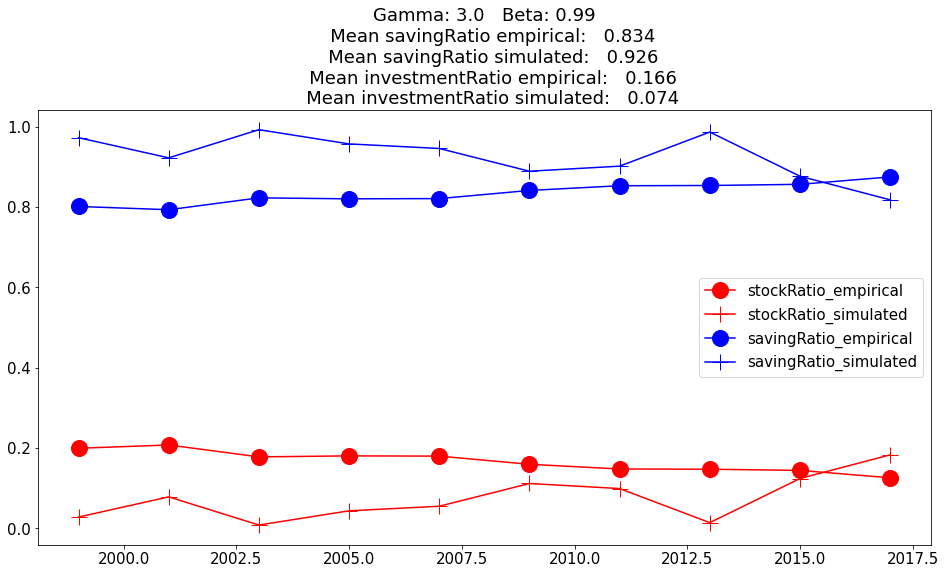

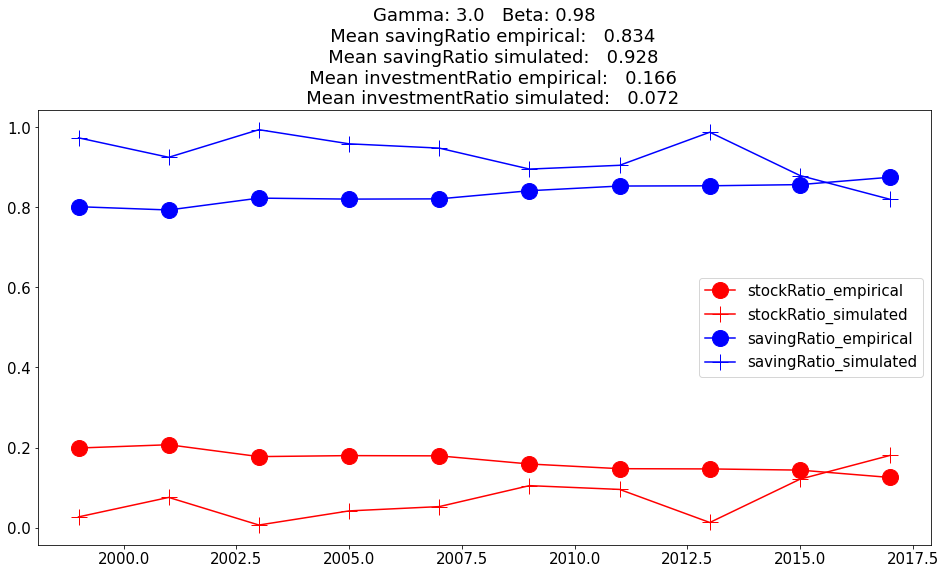

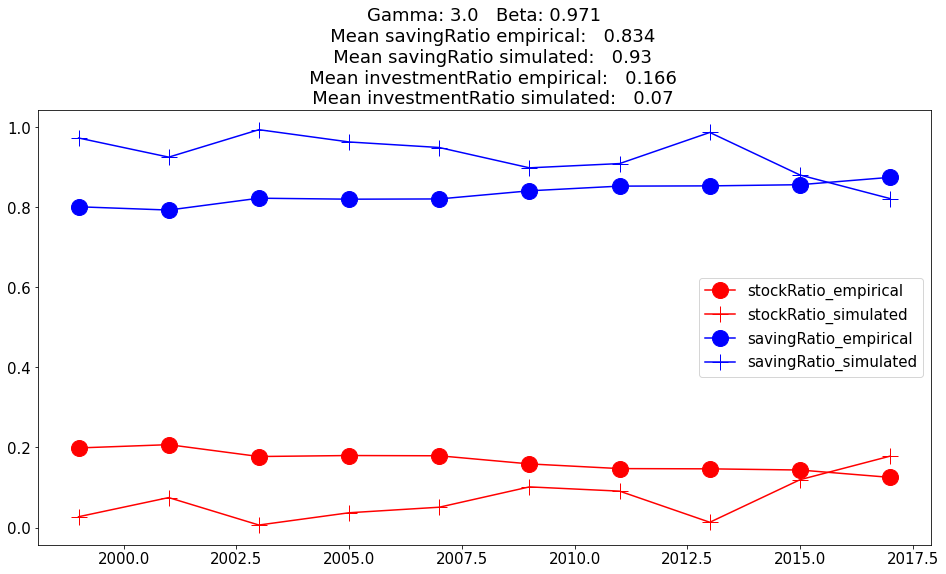

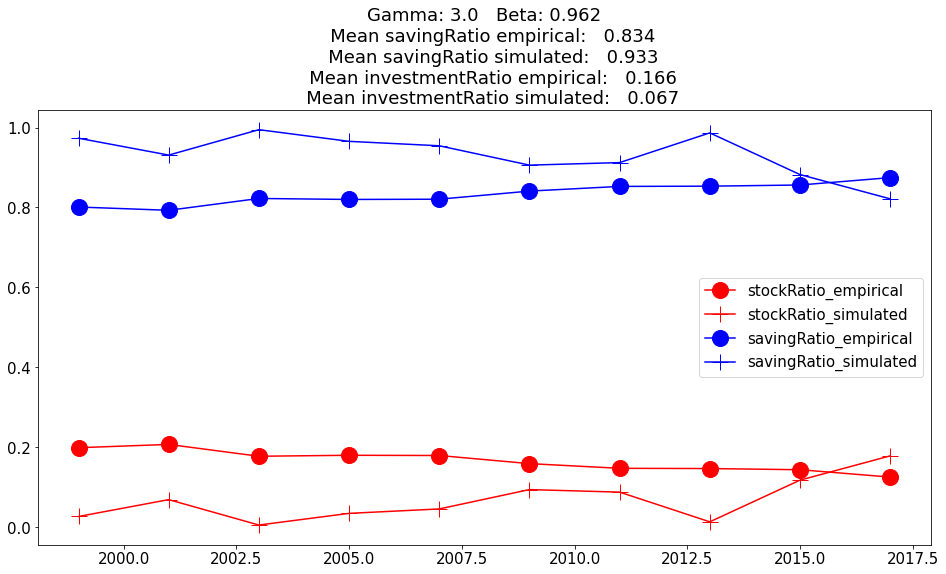

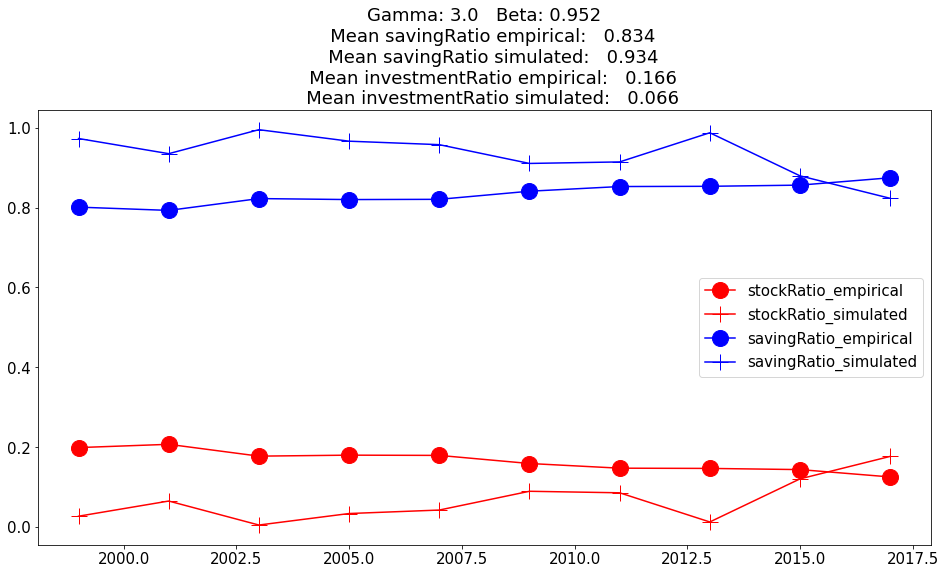

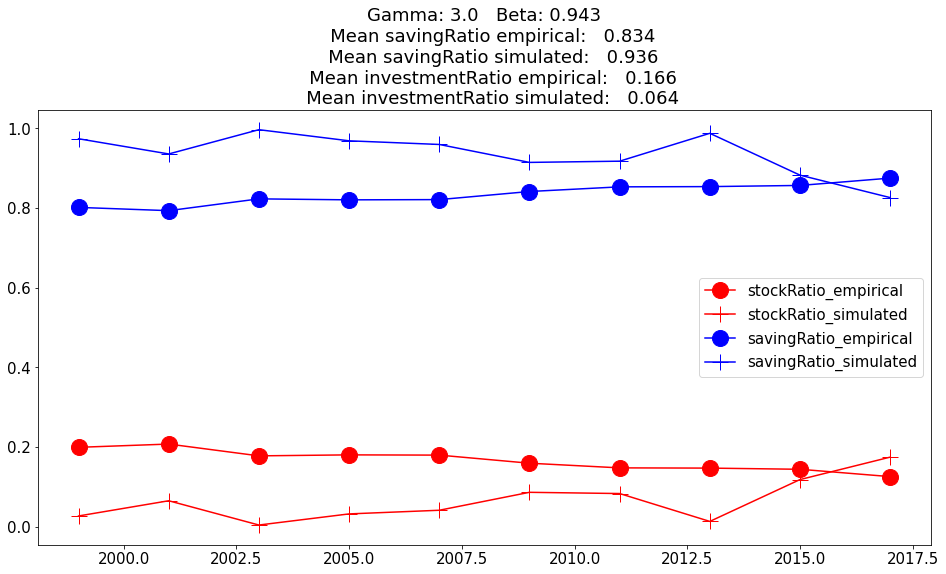

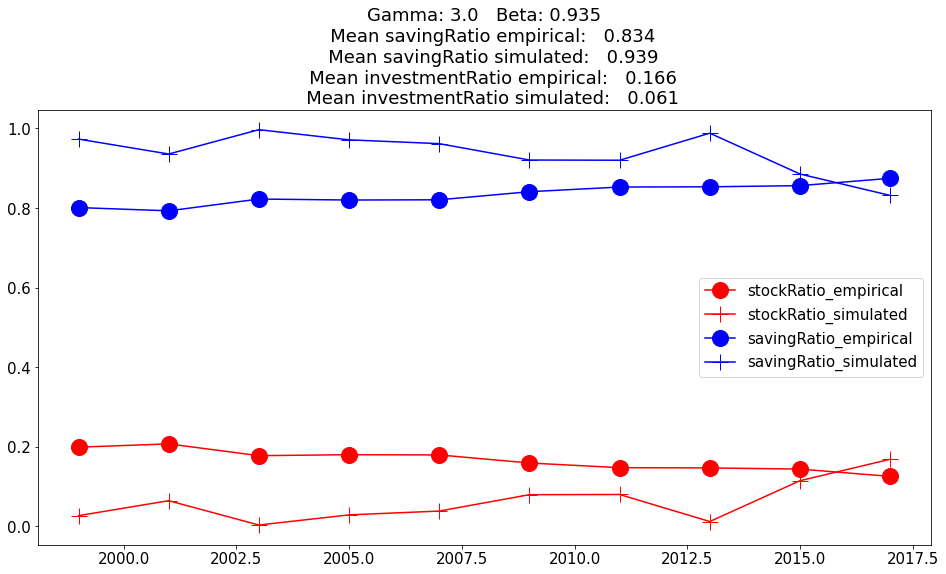

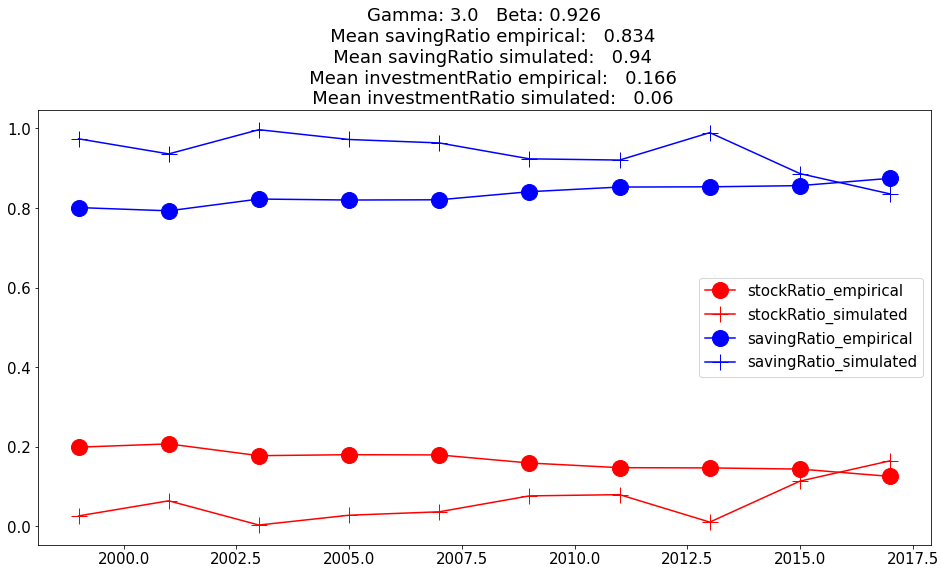

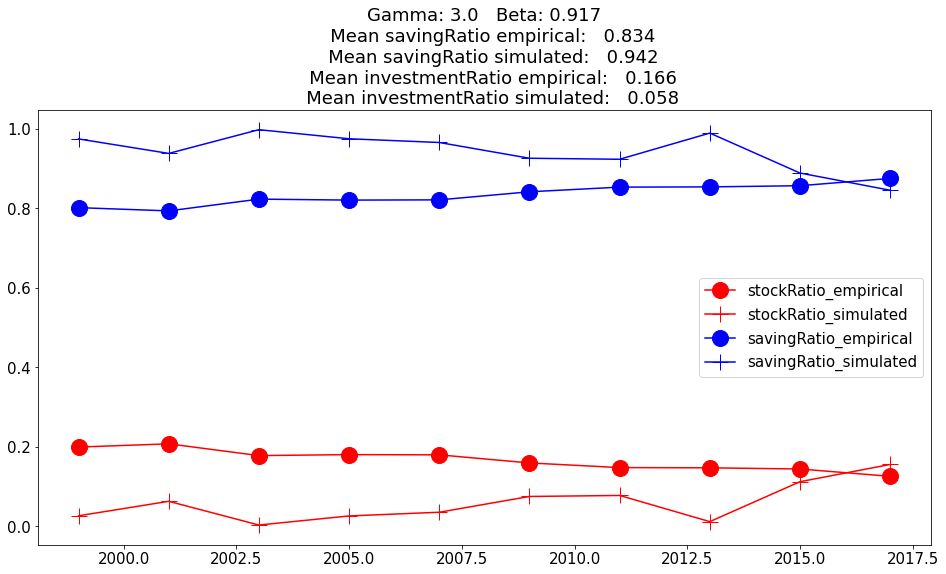

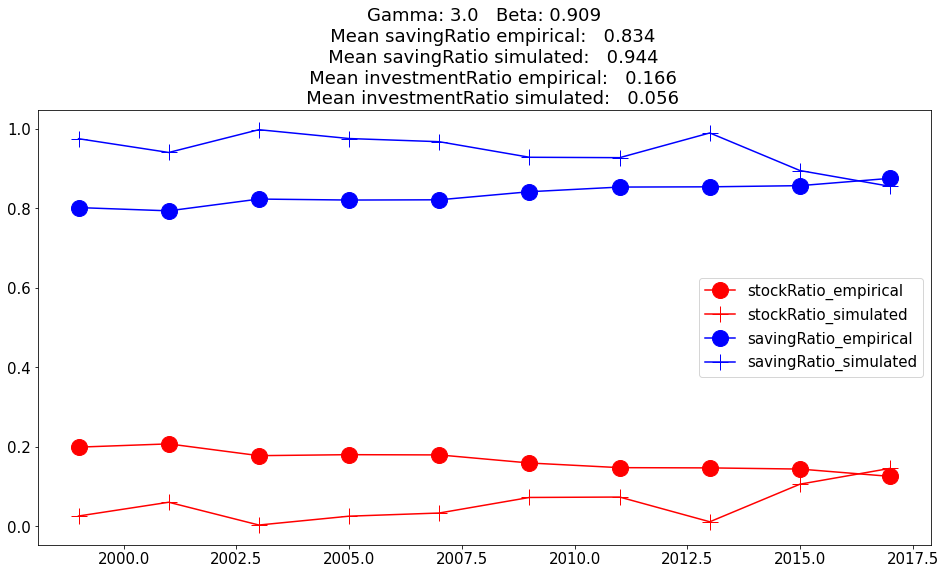

In [3]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhmType.append(np.load("waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
        waseozcbkhm = outputVariables(waseozcbkhmType)
        # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
        # generate comparison plots between empirical and simulated variables
        plt.figure()
        stockRatio_empirical = []
        savingRatio_empirical = []
        stockRatio_simulated = []
        savingRatio_simulated = []
        for year in years[:-1]:  
            df = Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]
            stockRatio_empirical.append((df.investmentAmount / (df.liquidWealth + df.investmentAmount)).mean())
            savingRatio_empirical.append((df.liquidWealth / (df.liquidWealth + df.investmentAmount)).mean())
            w = wwww[year - years[0],:]
            b = bbbb[year - years[0],:]
            k = kkkk[year - years[0],:]
            stockRatio_simulated.append((k/(b+k)).mean())
            savingRatio_simulated.append((b/(b+k)).mean())
        meanSaving_empirical = round(np.mean(savingRatio_empirical), 3)
        meanInvestment_empirical = round(np.mean(stockRatio_empirical), 3)
        meanSaving_simulated = round(np.mean(savingRatio_simulated), 3)
        meanInvestment_simulated = round(np.mean(stockRatio_simulated), 3)
        plt.title("Gamma: " + str(gamma) +  "   Beta: " + str(round(1/(1+beta_r),3)) + 
                  "\n   Mean savingRatio empirical:   " + str(meanSaving_empirical) +
                  "\n   Mean savingRatio simulated:   " + str(meanSaving_simulated) +
                  "\n   Mean investmentRatio empirical:   " + str(meanInvestment_empirical) +
                  "\n   Mean investmentRatio simulated:   " + str(meanInvestment_simulated) 
                 )
        plt.plot(years[:-1], stockRatio_empirical, 'ro-', label = "stockRatio_empirical", markersize = 16)
        plt.plot(years[:-1], stockRatio_simulated, 'r+-', label = "stockRatio_simulated", markersize = 16)
        plt.plot(years[:-1], savingRatio_empirical, 'bo-', label = "savingRatio_empirical", markersize = 16)
        plt.plot(years[:-1], savingRatio_simulated, 'b+-', label = "savingRatio_simulated", markersize = 16)
        plt.legend()

In [4]:
wealthLevel = []
consumption = []
investmentStock = []
bondOrcash = []
annuityAmount = []
participation = []
ownershipStatus = []
employment = []

for year in years:
    wealthLevel.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["wealthWithoutHomeEquity"].mean())
    investmentStock.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["investmentAmount"].mean())
    consumption.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["totalExpense"].mean())
    bondOrcash.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["liquidWealth"].mean())
    annuityAmount.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["annuityIRA"].mean())
    participation.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["participation"].mean())
    ownershipStatus.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["ownership"].mean())
    employment.append(Fdf[(Fdf['year'] == year) & (Fdf['ageHead'] >= 30+(year-1999)) & (Fdf['ageHead'] <= 60 + (year - 1999))]["employmentStatus"].mean())

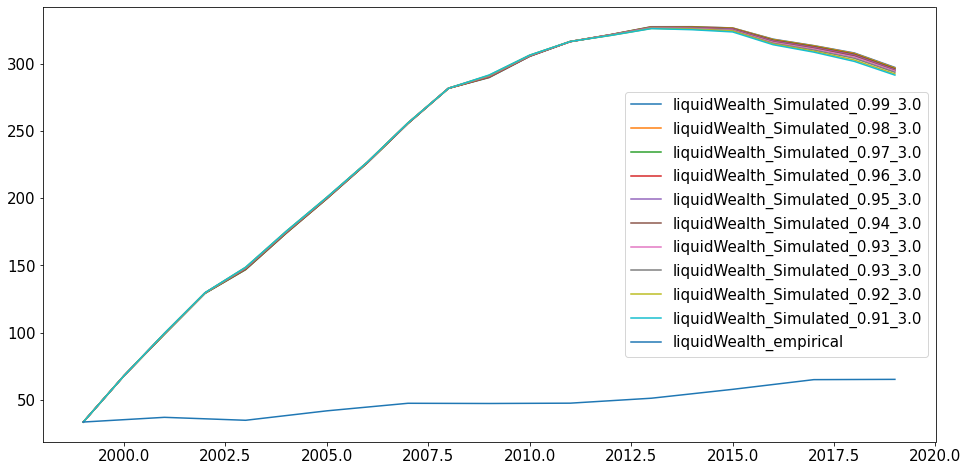

In [5]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhmType.append(np.load("waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
        waseozcbkhm = outputVariables(waseozcbkhmType)
        # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
        plt.plot(range(1999,2020), wwww.mean(axis = 1), label = "liquidWealth_Simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma))
plt.plot(years,np.array(investmentStock) + np.array(bondOrcash), label = "liquidWealth_empirical")
plt.legend()

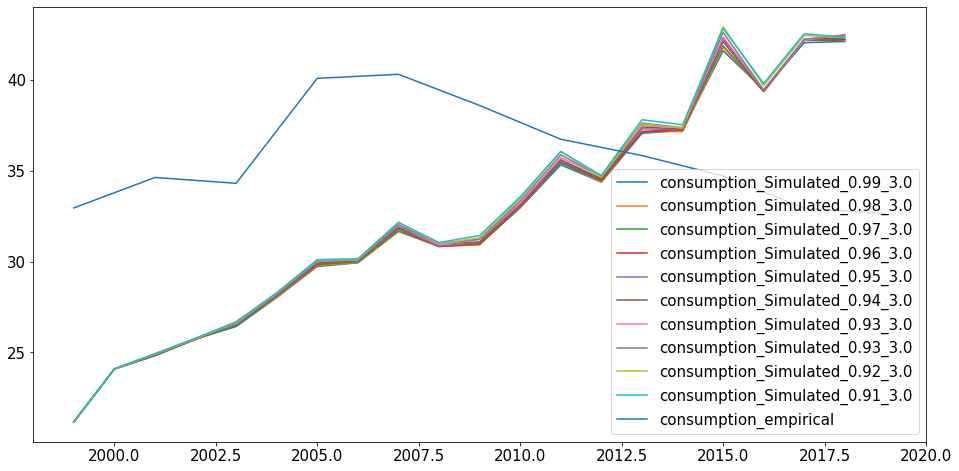

In [6]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhmType.append(np.load("waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
        waseozcbkhm = outputVariables(waseozcbkhmType)
        # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
        plt.plot(range(1999,2019), cccc.mean(axis = 1), label = "consumption_Simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma))
plt.plot(years,consumption, label = "consumption_empirical")
plt.legend()

In [7]:
import numpy as np 
np.load("constant/c_bar.npy")

array([13.02238636, 13.75309091, 14.48379545, 15.2145    , 15.94520455,
       16.67590909, 17.32681818, 18.06886364, 18.71659091, 19.23181818,
       19.75068182, 20.18863636, 20.62727273, 20.94181818, 21.28886364,
       21.48477273, 21.64431818, 21.75659091, 21.76227273, 21.84340909,
       22.00159091, 21.95      , 22.00590909, 21.84      , 21.81090909,
       21.73181818, 21.68318182, 21.47272727, 21.3425    , 21.1775    ,
       20.92681818, 20.63022727, 20.38727273, 20.18204545, 20.02568182,
       19.83681818, 19.48227273, 19.26136364, 19.03909091, 18.82840909,
       18.58181818, 18.32772727, 17.97295455, 17.80204545, 17.42704545,
       17.185     , 16.83431818, 16.61136364, 16.17818182, 15.74318182,
       15.31636364, 14.86022727, 14.43045455, 14.02636364, 13.47977273,
       13.15386364, 12.67113636, 12.18840909, 11.70568182, 11.22295455,
       10.74022727])

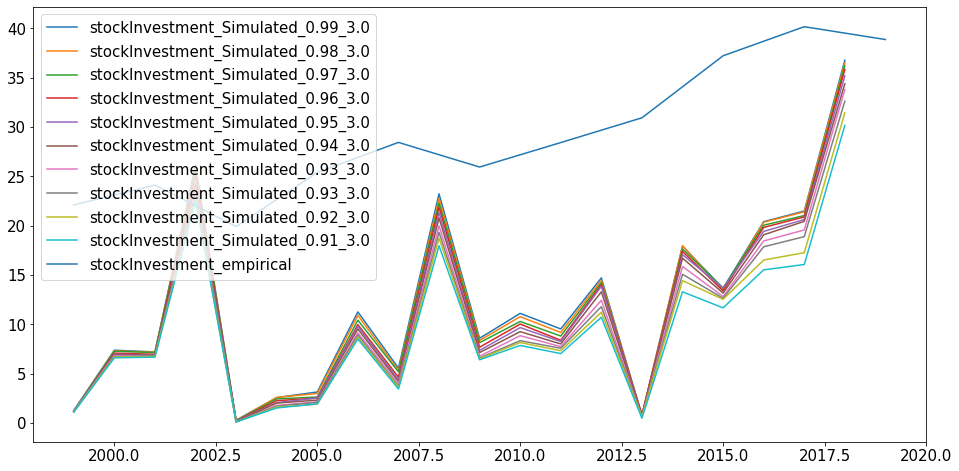

In [8]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhmType.append(np.load("waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
        waseozcbkhm = outputVariables(waseozcbkhmType)
        # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
        plt.plot(range(1999,2019), kkkk.mean(axis = 1), label = "stockInvestment_Simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma))
plt.plot(years,investmentStock, label = "stockInvestment_empirical")
plt.legend()

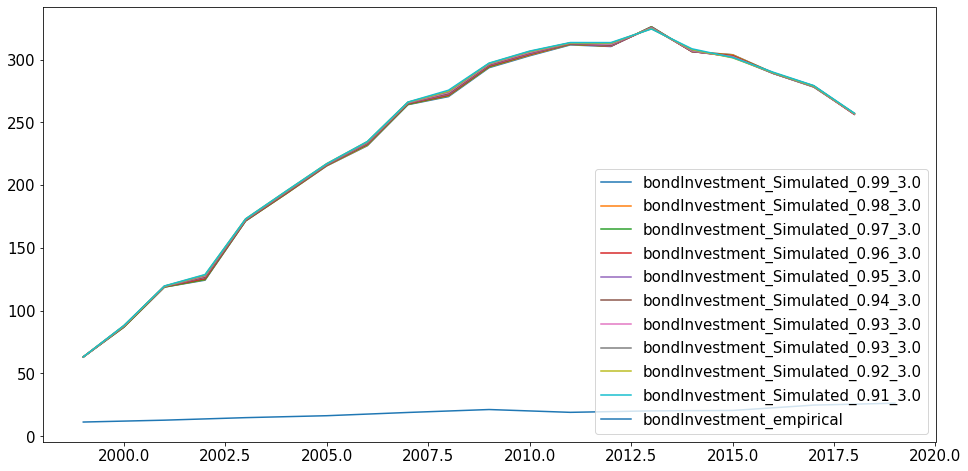

In [9]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhmType.append(np.load("waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
        waseozcbkhm = outputVariables(waseozcbkhmType)
        # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
        plt.plot(range(1999,2019), bbbb.mean(axis = 1), label = "bondInvestment_Simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma))
plt.plot(years,bondOrcash, label = "bondInvestment_empirical")
plt.legend()

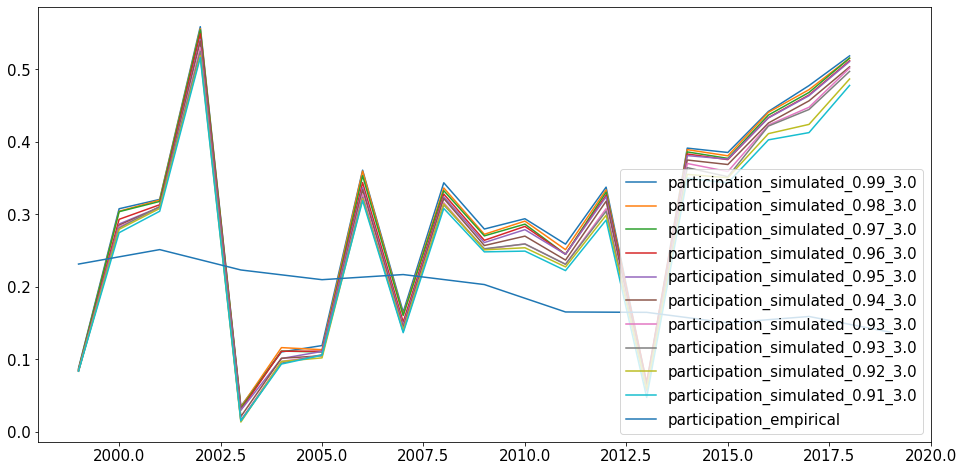

In [10]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhmType.append(np.load("waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
        waseozcbkhm = outputVariables(waseozcbkhmType)
        # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
        plt.plot(range(1999,2019), (kkkk>0).mean(axis = 1), label = "participation_simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma))
plt.plot(years,participation, label = "participation_empirical")
plt.legend()

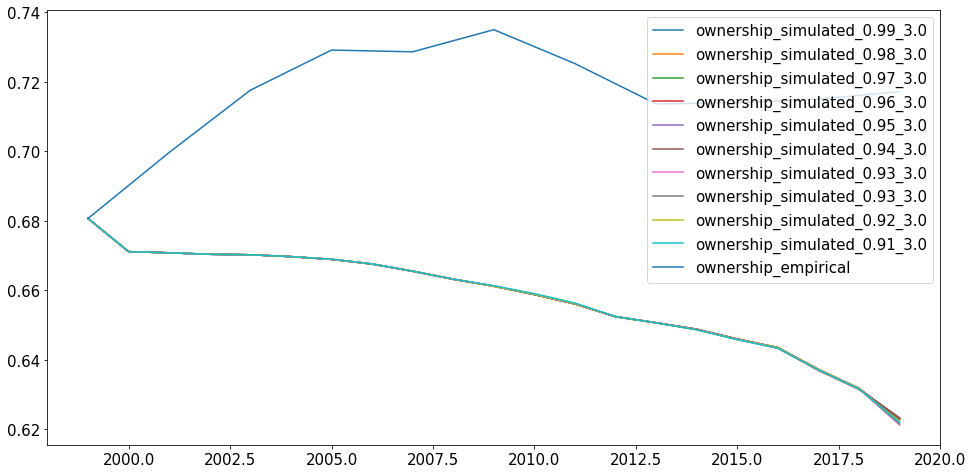

In [11]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhmType.append(np.load("waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
        waseozcbkhm = outputVariables(waseozcbkhmType)
        # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
        plt.plot(range(1999,2020), oooo.mean(axis = 1), label = "ownership_simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma))
plt.plot(years,ownershipStatus, label = "ownership_empirical")
plt.legend()

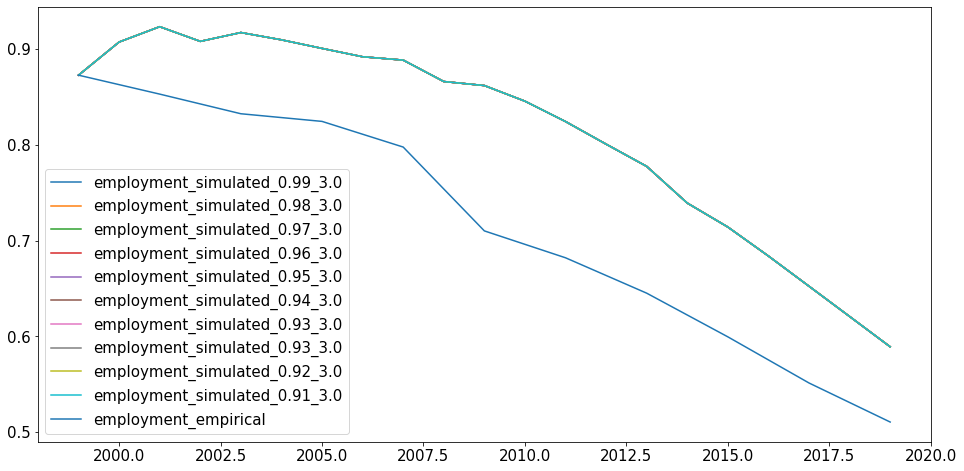

In [12]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhmType.append(np.load("waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
        waseozcbkhm = outputVariables(waseozcbkhmType)
        # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
        plt.plot(range(1999,2020), eeee.mean(axis = 1), label = "employment_simulated_" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma))
# fix here the retirment people is unemployed. 
plt.plot(years,employment, label = "employment_empirical")
plt.legend()

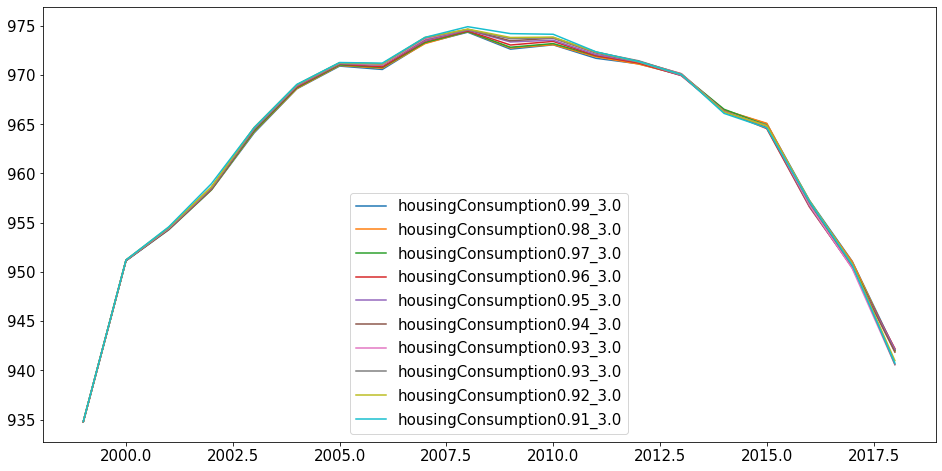

In [13]:
for gamma in Gamma:
    for beta_r in Beta_r:
        waseozcbkhmType = []
        for agentType in AgentType:
            ### load in the data 
            fileName = agentType + "_" + str(beta_r) + "_" + str(gamma)
            waseozcbkhmType.append(np.load("waseozcbkhm_" + fileName + ".npy", allow_pickle=True))
        waseozcbkhm = outputVariables(waseozcbkhmType)
        # [ws,ab,ss,es,os,zs,cs,bs,ks,hs,ms]
        wwww, aaaa, ssss, eeee, oooo, zzzz, cccc, bbbb, kkkk, hhhh, mmmm = waseozcbkhm
        plt.plot(range(1999,2019), hhhh.mean(axis = 1), label = "housingConsumption" + str(round(1/(1+beta_r), 2)) + "_" + str(gamma))
plt.legend()